<a href="https://colab.research.google.com/github/yasmimvso/titanic-mlp/blob/main/Projeto_mlpSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛥️ **MLP Titanic** 🛥️
Este projeto utiliza técnicas de aprendizado de máquina para prever a sobrevivência de passageiros do Titanic, empregando o classificador MLP com dados fornecidos pelo Kaggle.

*   🗂️: Sistemas Inteligentes (IF684 - EC)
*   **Grupo 2 - Integrantes**
  - Bianca Duarte Santos (bds)
  - Dara Caroline de Souza Vasconcelos (dcsv)
  - Maria Eduarda Nunes de Almeida (mena)
  - Rafael da Silva Barros (rsb7)
  - Yasmim Vitória Silva de Oliveira (yvso)


## Bibliotecas

In [ ]:
! pip install optuna
! pip install tabulate

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tabulate import tabulate, tabulate_formats


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve
from copy import deepcopy


from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## Github repositório Titanic-db

In [ ]:
! git clone https://github.com/yasmimvso/titanic-db.git

fatal: destination path 'titanic-db' already exists and is not an empty directory.


In [ ]:
file = "/content/titanic-db/titanic/train.csv"

db_titanic =  pd.read_csv(file)


## Functions

In [ ]:
def plot_validation_error_vs_epoch(model, string, X_t, y_t, max_epochs=100):
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2, random_state=42)
    validation_errors = []

    # Deep copy do modelo para preservar o estado inicial
    model = deepcopy(model)

    # Função para treinar por uma época e calcular o erro de validação
    def train_and_record_error(model, X_train, y_train, X_val, y_val, errors_list):
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))
        y_val_pred = model.predict(X_val)
        validation_error = 1 - accuracy_score(y_val, y_val_pred)
        errors_list.append(validation_error)

    for epoch in range(max_epochs):
        train_and_record_error(model, X_train, y_train, X_val, y_val, validation_errors)

    # Plotar o erro de validação em função das épocas
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, max_epochs + 1), validation_errors, label='Validation Error', marker='o')
    plt.title(string)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Error')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def infoClassificador(model, test_y, test_X):

  ##  Acurácia, Precision e Recall.

  pred_y = model.predict(test_X)

  # Medindo a acurácia do modelo
  accuracy = accuracy_score(test_y, pred_y)

  print(f"\nAcurácia do modelo {accuracy}")

  # model.score(X_test, y_test)

  # Relatório de classificação do modelo
  print(f"Classification Report")
  print(classification_report(test_y, pred_y))

In [ ]:
def plot_confusion_matrix(string, modelo_ml, X_test, y_test):
  y_pred = modelo_ml.predict(X_test)
  # Create the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cm_percentage = cm / cm.sum(axis=1, keepdims=True)

  # Create a heatmap of the confusion matrix
  labels = ["Não Sobreviveu", 'Sobreviveu']
  sns.heatmap(cm_percentage, annot=True, cmap="Greens", fmt=".2f", xticklabels=labels, yticklabels=labels)
  # Set the labels for the axes
  plt.xlabel('Predict')
  plt.ylabel("True")

  # Set the title of the plot
  plt.title(string)

  # Show the plot
  plt.show()

In [ ]:
def plot_validation_error(model, X_t, y_t, hidden_layer_sizes):
    # Dividir os dados em treinamento e validação
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2, random_state=42)
    validation_errors = []

    for size in hidden_layer_sizes:
        model.hidden_layer_sizes = size
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        validation_error = 1 - accuracy_score(y_val, y_val_pred)
        validation_errors.append(validation_error)

    # Plotar o erro de validação
    plt.figure(figsize=(10, 6))
    plt.plot([str(size) for size in hidden_layer_sizes], validation_errors, marker='o')
    plt.title('Validation Error vs. Hidden Layer Sizes')
    plt.xlabel('Hidden Layer Sizes')
    plt.ylabel('Validation Error')
    plt.grid(True)
    plt.show()

# Análise de Dados

## Análise Geral

| Feature                                       | Variable    | Value Type                                       |   |
|-----------------------------------------------|-------------|--------------------------------------------------|---|
| Index (Starting from 1)                    | PassangerId | int
| Survival    (Target Variable)                         | Survived | binary
|Ticket Class | Pclass | 1: 1st; 2: 2nd; 3: 3rd
|Sex	| Sex	| categorical code (female or male)
|Age | Age | float(years)
| Number of Sibilings/spouses* | Sibsp | int
| Number of parents/children** | Parch | int
| Ticket |	Ticket | int
| Amount paid for the ticket	| Fare | float
|Cabin |	Cabin | string
| Port of Embarkation | Embarked	| categorial code (C: Cherbourg, Q: Queenstown, S: Southampton)

### Observações
Age:  A idade é fracionada se for menor que 1. Se a idade for estimada, está na forma de xx.5
#### Relações Familiares
O dataset define relações famiiares da seguinte forma:
<br>
- \* Sibilings: irmão, irmã, meio-irmão, meia-irmã
<br>
- \** Spouses: marido, esposa (amantes e noivos foram ignorados)
<br>
-  Parent: mãe, pai
-  Child: filha, filho, enteada, enteado
<br>
Algumas crianças viajaram apenas com uma babá, portanto parch=0 para elas.

In [ ]:
display(db_titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
#Análise Estatística dos Dados
db_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
print('Tipos de Dados:')
db_titanic.info()

print('\nNúmero de linhas e colunas:')
db_titanic.shape

Tipos de Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Número de linhas e colunas:


(891, 12)

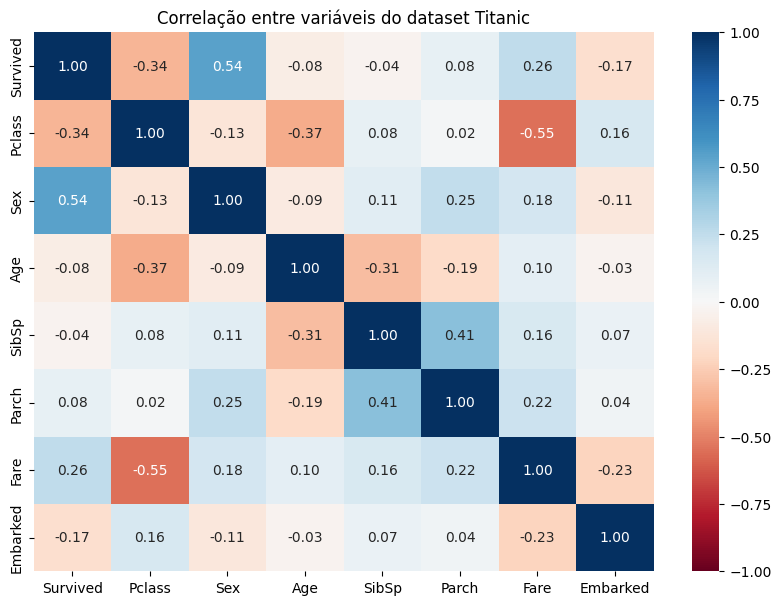

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
df  = db_titanic
#Excluir variáveis categoricas
df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
#Converter male para 0 e female para 1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
#Converter Embarked para 0, 1, 2
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
sns.heatmap(df.corr(),
            annot = True,
            fmt = '.2f',
            cmap='RdBu',
            vmin = -1.0,
            vmax = 1.0
            )
plt.title('Correlação entre variáveis do dataset Titanic')
plt.show()

In [ ]:
#Verificar a existência de valores nulos
db_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Percebemos a presença de valores nulos em Embarked, Cabin e Age. Tomaremos as seguintes atitudes na Limpeza de Dados:
* A quantidade de valores nulos em Cabin é alta (77% da coluna em falta), logo, essa variável não será tão impactante no problema. Iremos removê-la.
* Para Embarked, apenas duas linhas tem valores nulos. Vamos eliminá-las.
* Para Age, 177 valores faltantes (19,86%). Por isso, vamos estimar esses valores. Utilizamos Regressão Linear para fazê-lo.

In [ ]:
print('Nome das colunas:')
db_titanic.columns

Nome das colunas:


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Análise Exploratória

### Variáveis Numéricas

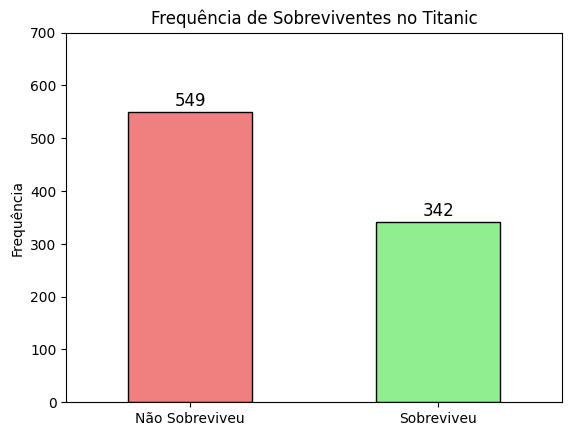

In [ ]:
# Contar a frequência de sobreviventes e não sobreviventes
survival_counts = db_titanic['Survived'].value_counts()

# Criar o gráfico de barras com cores mais leves
colors = ['lightcoral', 'lightgreen']
ax = survival_counts.plot(kind='bar', color=colors, edgecolor='black')

# Adicionar os valores em cada barra com um tamanho maior de fonte
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=12)

# Configurar o título
plt.title('Frequência de Sobreviventes no Titanic')
plt.xticks(ticks=[0, 1], labels=['Não Sobreviveu', 'Sobreviveu'], rotation=0)
plt.ylabel('Frequência')
plt.ylim(0, 700)

# Remover o rótulo do eixo x
ax.set_xlabel('')

#plt.figure(figsize=(14, 10))

plt.show()


In [ ]:

fig = make_subplots (rows=4, cols=1) #cria espaço com 4 linhas
fig.add_trace(go.Box(x=db_titanic['Age'], name = 'Idade'), row=1, col=1) #cria na primeira linha um boxplot sobre a idade dos pacientes
fig.add_trace(go.Box(x=db_titanic['SibSp'], name = 'Número de Irmãos/Conjuges'), row=2, col=1)
fig.add_trace(go.Box(x=db_titanic['Fare'], name = 'Valor do Bilhete'), row=3, col=1)
fig.add_trace(go.Box(x=db_titanic['Parch'], name = 'Número de Pais/Filhos'), row=4, col=1)
fig.update_layout(height = 800, template='plotly_dark')
fig.show()

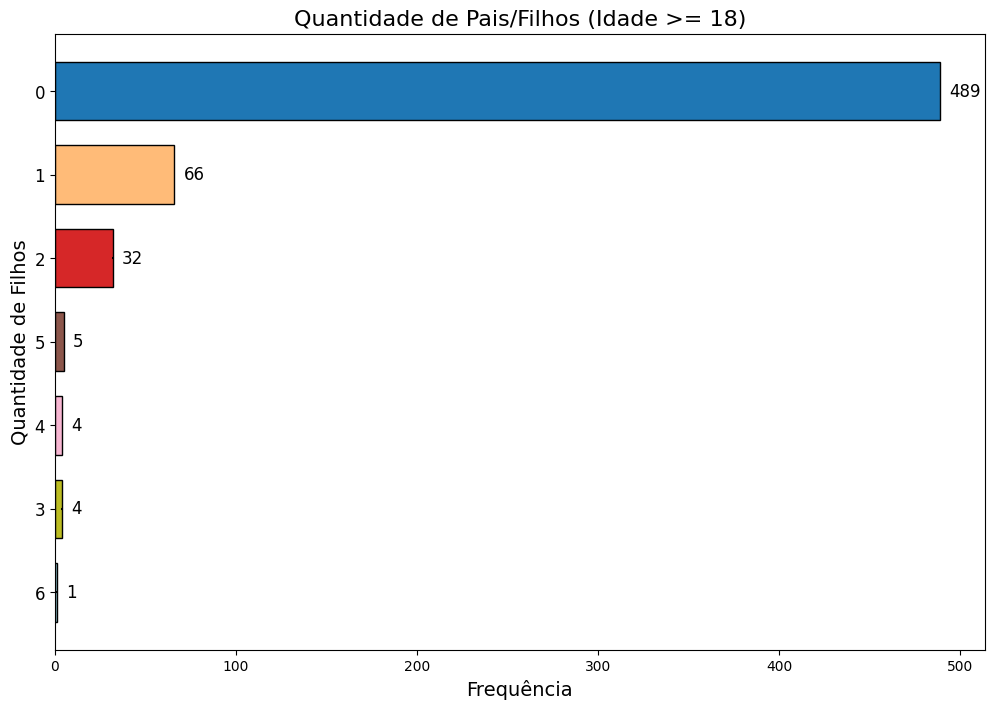

In [ ]:


# Filtra os valores onde 'Age' é maior ou igual a 20.00
filtered_data = db_titanic.loc[db_titanic['Age'] >= 18.00]

# obtém a contagem de ocorrências de cada valor único na coluna "Parch"
contagem = filtered_data['Parch'].value_counts()

# separa os valores únicos e as contagens em listas separadas
valores_unicos = contagem.index.tolist()
frequencia = contagem.tolist()

# Example data
y_pos = np.arange(len(valores_unicos))
performance = contagem.tolist()
error = np.random.rand(len(valores_unicos))

# Cores diferentes para cada barra
colors = plt.cm.tab20(np.linspace(0, 1, len(valores_unicos)))



plt.figure(figsize=(12, 8))  # Aumenta o tamanho da figura
bars = plt.barh(y_pos, performance, xerr=error, align='center', height=0.7, color=colors, edgecolor='black')  # Muda a cor das barras

plt.yticks(y_pos, labels=valores_unicos, fontsize=12)
plt.gca().invert_yaxis()  # Inverte o eixo y
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Quantidade de Filhos', fontsize=14)
plt.title('Quantidade de Pais/Filhos (Idade >= 18)', fontsize=16)

# Adiciona os valores das frequências nas barras
for bar, value in zip(bars, performance):
    x_position = bar.get_width() + 5
    alignment = 'left'
    color = 'black'
    plt.text(x_position, bar.get_y() + bar.get_height()/2, str(value), ha=alignment, va='center', fontsize=12, color=color)

#plota o gráfico de barras

plt.show()


### Dados categóricos


In [ ]:
# Verificar os valores únicos e suas contagens na coluna 'Pclass'
print(db_titanic['Pclass'].value_counts())
print(db_titanic['Sex'].value_counts())
print(db_titanic['Embarked'].value_counts())
print(db_titanic['Survived'].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Survived
0    549
1    342
Name: count, dtype: int64


In [ ]:
fig = make_subplots (rows=3, cols=1)
fig.add_trace(go.Bar(y= db_titanic['Pclass'].value_counts(), x = ['3ª classe', '1ª classe', '2ª classe'], name='Classe'), row=1, col=1)
fig.add_trace(go.Bar(y= db_titanic['Sex'].value_counts(), x = ['Masculino', 'Feminino'], name='Sexo'), row=2, col=1)
fig.add_trace(go.Bar(y= db_titanic['Embarked'].value_counts(), x = ['Southampton', 'Cherbourg', 'Queenstown'], name='Portão de Embarque'), row=3, col=1)
fig.update_layout(
    title={
        'text': "Análise de Variáveis Categóricas",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    template='plotly_dark',
    height=800,
    width=1000
)
fig.show()

In [ ]:
print(db_titanic.groupby(['Pclass', 'Survived']).count()['PassengerId'])
print(db_titanic.groupby(['Sex', 'Survived']).count()['PassengerId'])
print(db_titanic.groupby(['Embarked', 'Survived']).count()['PassengerId'])

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: PassengerId, dtype: int64
Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: PassengerId, dtype: int64
Embarked  Survived
C         0            75
          1            93
Q         0            47
          1            30
S         0           427
          1           217
Name: PassengerId, dtype: int64


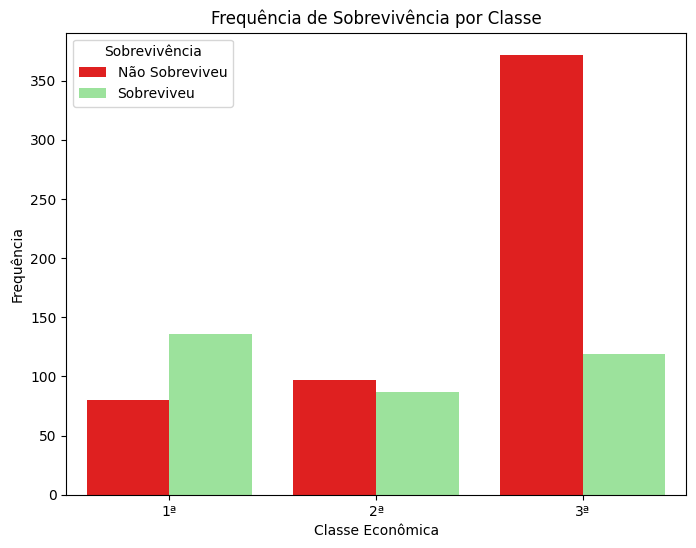

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=db_titanic, x='Pclass', hue='Survived', palette={0: 'red', 1: 'lightgreen'})

plt.title("Frequência de Sobrevivência por Classe")
plt.xlabel('Classe Econômica')
plt.ylabel("Frequência")

plt.xticks(ticks=[0, 1, 2], labels=['1ª', '2ª', '3ª'])
plt.legend(title='Sobrevivência', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.show()

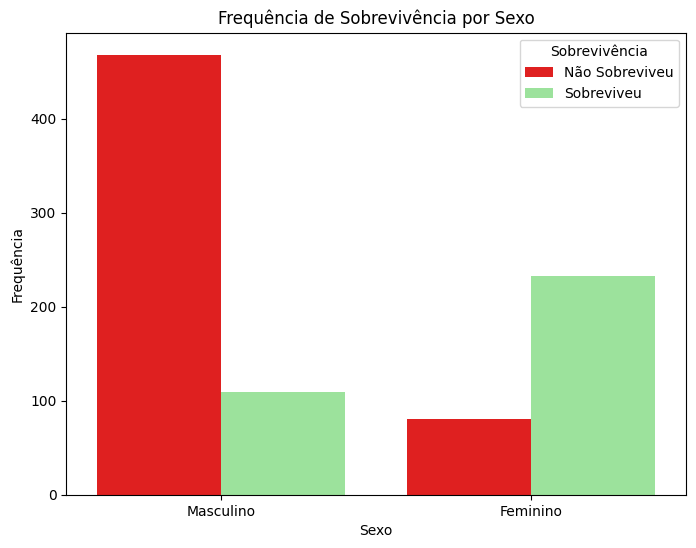

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=db_titanic, x='Sex', hue='Survived', palette={0: 'red', 1: 'lightgreen'})

plt.title("Frequência de Sobrevivência por Sexo")
plt.xlabel('Sexo')
plt.ylabel("Frequência")

plt.xticks(ticks=[0, 1], labels=['Masculino', 'Feminino'])
plt.legend(title='Sobrevivência', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.show()

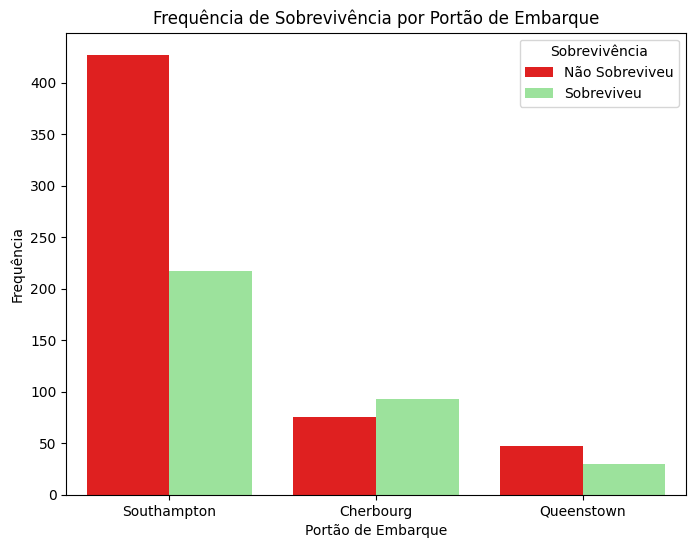

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=db_titanic, x='Embarked', hue='Survived', palette={0: 'red', 1: 'lightgreen'})

plt.title("Frequência de Sobrevivência por Portão de Embarque")
plt.xlabel('Portão de Embarque')
plt.ylabel("Frequência")

plt.xticks(ticks=[0, 1, 2], labels=[ 'Southampton', 'Cherbourg', 'Queenstown'])
plt.legend(title='Sobrevivência', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic

# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Calcular os valores máximos e mínimos da idade
age_min = df['Age'].min()
age_max = df['Age'].max()

# Definir classes de idade
bins = [0.0, 18.0, 60.0, age_max]  # max() + 1 para incluir o valor máximo no último bin
labels = ['Não Adulto', 'Adulto', 'Não Adulto']

# Categorizar idades
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, ordered=False)

# Bebês, Crianças, Adolescentes e Idosos -> Não Adultos
#df['AgeClass'] = df['AgeClass'].replace(['Bebês', 'Crianças', 'Adolescentes', 'Idosos'], 'Não Adultos')
#df[''] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência entre Adultos e Não-Adultos por Sexo",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Definir classes de idade
bins = [0, 18, 30, 60, df['Age'].max()]
labels = ['Não Adultos', 'Adultos 18-30', 'Adultos 30-60', 'Não Adultos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Não Adultos e Adultos (com 2 faixas) por Sexo",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Definir classes de idade
bins = [0, 18, 30, 40, 50, 60, df['Age'].max()]
labels = ['Não Adultos', 'Adultos 18-30', 'Adultos 30-40', 'Adultos 40-50', 'Adultos 50-60', 'Não Adultos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Não Adultos e Adultos (com 4 faixas) por Sexo",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Calcular os valores máximos e mínimos da idade
age_min = df['Age'].min()
age_max = df['Age'].max()

# Definir classes de idade
bins = [0, 2, 12, 17, 59, age_max]
labels = ['Bebês', 'Crianças', 'Adolescentes', 'Adultos', 'Idosos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Sexo e 5 Faixas de Idade",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


df = db_titanic.copy()
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Calcular os valores máximos e mínimos da idade
age_min = df['Age'].min()
age_max = df['Age'].max()

# Definir classes de idade
bins = [0, 2, 12, 17, 59, age_max]
labels = ['Bebês', 'Crianças', 'Adolescentes', 'Adultos', 'Idosos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Reagrupar as classes de idade em três categorias: "Crianças+Bebês", "Idosos+Adolescentes" e "Adultos"
df['AgeGroup'] = df['AgeClass'].replace({
    'Bebês': 'Crianças+Bebês',
    'Crianças': 'Crianças+Bebês',
    'Adolescentes': 'Idosos+Adolescentes',
    'Idosos': 'Idosos+Adolescentes'
})

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeGroup'].value_counts().index,
                         y=sub_df['AgeGroup'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeGroup'].value_counts().index,
                         y=sub_df['AgeGroup'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeGroup'].value_counts().index,
                         y=sub_df['AgeGroup'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Sexo e Classes de Idade Agrupadas",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()


# Tratamento e Limpeza de Dados

In [ ]:
# Seleção de informações mais relevantes em traino

titanic_feature = db_titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']]
# titanic_feature = db_titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Fare']]
titanic_target = db_titanic['Survived']

print(titanic_target.value_counts())


Survived
0    549
1    342
Name: count, dtype: int64


## Tratando variáveis

Definindo tratamentos para coluna de Age

In [ ]:

# transformando de dados categóricos para numericos
titanic_feature['Sex'] = titanic_feature['Sex'].map({'male': 0, 'female': 1})
titanic_feature['Embarked'] = titanic_feature['Embarked'].map({'C': 0.0, 'Q': 0.5, 'S': 1.0})
# titanic_feature['Age'] = titanic_feature['Age'] /titanic_feature['Age'].abs().max()
titanic_feature['Pclass'] = titanic_feature['Pclass'].map({1: 0, 2: 0.5, 3: 1})
titanic_feature['SibSp'] = titanic_feature['SibSp']/titanic_feature['SibSp'].abs().max()
titanic_feature['Parch'] = titanic_feature['Parch']/titanic_feature['Parch'].abs().max()


## normalizar os dados entre o e 1
display(titanic_feature)

titanic_feature.isnull().sum()



<ipython-input-64-801e3875e650>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_feature['Sex'] = titanic_feature['Sex'].map({'male': 0, 'female': 1})
<ipython-input-64-801e3875e650>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_feature['Embarked'] = titanic_feature['Embarked'].map({'C': 0.0, 'Q': 0.5, 'S': 1.0})
<ipython-input-64-801e3875e650>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1.0,0,22.0,0.125,0.000000,1.0
1,0.0,1,38.0,0.125,0.000000,0.0
2,1.0,1,26.0,0.000,0.000000,1.0
3,0.0,1,35.0,0.125,0.000000,1.0
4,1.0,0,35.0,0.000,0.000000,1.0
...,...,...,...,...,...,...
886,0.5,0,27.0,0.000,0.000000,1.0
887,0.0,1,19.0,0.000,0.000000,1.0
888,1.0,1,NaN,0.125,0.333333,1.0
889,0.0,0,26.0,0.000,0.000000,0.0


Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

In [ ]:
# Valores NaN idntificados, dados corrompidos. Foram 177 linhas

## criaando nova coluna 'Missing' referenciando as idades faltantes

titanic_feature['Missing'] = titanic_feature['Age'].isnull().astype(int)

# Linhas de treino e target serão
age_min = titanic_feature['Age'].min()
age_max = titanic_feature['Age'].max()
age_mean = (age_max + age_min) / 2

titanic_feature['Age'] =  titanic_feature['Age'].fillna(age_mean)

## Existe duas linhas referentes a valores faltantes de Embarque. Irei fazer um drop pois a quantidade é irrelevante
filtered_titanic_feature = titanic_feature[~titanic_feature['Embarked'].isnull()]

filtered_titanic_target = titanic_target.loc[filtered_titanic_feature.index]


display(filtered_titanic_feature)
display(filtered_titanic_target)

<ipython-input-65-d594aeb23194>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_feature['Missing'] = titanic_feature['Age'].isnull().astype(int)
<ipython-input-65-d594aeb23194>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_feature['Age'] =  titanic_feature['Age'].fillna(age_mean)


,Pclass,Sex,Age,SibSp,Parch,Embarked,Missing
0,1.0,0,22.00,0.125,0.000000,1.0,0
1,0.0,1,38.00,0.125,0.000000,0.0,0
2,1.0,1,26.00,0.000,0.000000,1.0,0
3,0.0,1,35.00,0.125,0.000000,1.0,0
4,1.0,0,35.00,0.000,0.000000,1.0,0
...,...,...,...,...,...,...,...
886,0.5,0,27.00,0.000,0.000000,1.0,0
887,0.0,1,19.00,0.000,0.000000,1.0,0
888,1.0,1,40.21,0.125,0.333333,1.0,1
889,0.0,0,26.00,0.000,0.000000,0.0,0


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

**Função utilizada para otimizar Age (Iremos usar para verificar desempenho do modelo)**

In [ ]:
#Converter a classe -> fiz no df só para testar, aí é só inserir no db_titanic
#tem que usar ANTES de normalizar os dados, deu erro na ultima execução pq eu normalizei primeiro
# Definir classes de idade
age_max = filtered_titanic_feature['Age'].max() + 1
bins = [0.0, 18.0, 60.0, age_max]  # max() + 1 para incluir o valor máximo no último bin
labels = ['Não Adulto', 'Adulto', 'Não Adulto']
filtered_titanic_feature['Age'] = pd.cut(filtered_titanic_feature['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)
print(filtered_titanic_feature['Age'].value_counts())
#Converter não adulto em 0 e Adulto em 1
filtered_titanic_feature['Age'] = filtered_titanic_feature['Age'].replace(['Não Adulto'], 0)
filtered_titanic_feature['Age'] = filtered_titanic_feature['Age'].replace(['Adulto'], 1)
print(filtered_titanic_feature['Age'].value_counts())
#Inserir AgeClass no df após a coluna Age
#df.insert(2, 'AgeClass', df['AgeClass'])
print(filtered_titanic_feature)

print(filtered_titanic_feature.isnull().sum())

Age
Adulto        751
Não Adulto    138
Name: count, dtype: int64
Age
1    751
0    138
Name: count, dtype: int64
     Pclass  Sex Age  SibSp     Parch  Embarked  Missing
0       1.0    0   1  0.125  0.000000       1.0        0
1       0.0    1   1  0.125  0.000000       0.0        0
2       1.0    1   1  0.000  0.000000       1.0        0
3       0.0    1   1  0.125  0.000000       1.0        0
4       1.0    0   1  0.000  0.000000       1.0        0
..      ...  ...  ..    ...       ...       ...      ...
886     0.5    0   1  0.000  0.000000       1.0        0
887     0.0    1   1  0.000  0.000000       1.0        0
888     1.0    1   1  0.125  0.333333       1.0        1
889     0.0    0   1  0.000  0.000000       0.0        0
890     1.0    0   1  0.000  0.000000       0.5        0

[889 rows x 7 columns]
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
Missing     0
dtype: int64


<ipython-input-66-94276cd979ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_titanic_feature['Age'] = pd.cut(filtered_titanic_feature['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)
<ipython-input-66-94276cd979ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_titanic_feature['Age'] = filtered_titanic_feature['Age'].replace(['Não Adulto'], 0)
<ipython-input-66-94276cd979ad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

## Tratando Desbalanceamento

Utilizamento da bilioteca imbalanced do sklearning para balancear o modelo.

Funções de Balanceamento :

* SMOTE
* RANDON SAMPLE

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### Rondon Undersample

Essa função visa os dados de maoria, tendendo diminuir de forma aleatória o dado de maioria para 1:1

In [ ]:
import  matplotlib.pyplot as mlp

rus =  RandomUnderSampler(sampling_strategy = 1)
titanic_feature , titanic_target = rus.fit_resample(titanic_feature, titanic_target)

ax = titanic_target.value_counts()


### Randon Oversample

Essa função visa os dados de minoria, tendendo aumentar de forma aleatória o dado de menoria para 1:1 com o dado de maioria

In [ ]:
## quando faz o oversample os valores ficam comrrompidos

ros =  RandomOverSampler(sampling_strategy = 'not majority')
titanic_feature , titanic_target = ros.fit_resample(filtered_titanic_feature, filtered_titanic_target)

ax = titanic_target.value_counts()
print(ax)
# .mpl.pie(outopct='%.2f')
# _ = ax.set_title("UnderSampling")

Survived
0    549
1    549
Name: count, dtype: int64


In [ ]:
titanic_feature

,Pclass,Sex,Age,SibSp,Parch,Embarked,Missing
0,1.0,0,1,0.125,0.000000,1.0,0
1,0.0,1,1,0.125,0.000000,0.0,0
2,1.0,1,1,0.000,0.000000,1.0,0
3,0.0,1,1,0.125,0.000000,1.0,0
4,1.0,0,1,0.000,0.000000,1.0,0
...,...,...,...,...,...,...,...
1093,1.0,0,1,0.000,0.000000,1.0,0
1094,1.0,1,0,0.000,0.166667,0.0,0
1095,0.0,1,1,0.125,0.000000,0.0,0
1096,1.0,1,1,0.000,0.000000,0.5,1


# Split de Dados

In [ ]:
## Dividir banco de dados filtrados em teste e treino
## Utilizarei a divisão padrão de 25%

X_train, X_test, y_train, y_test = train_test_split(titanic_feature, titanic_target, test_size = 0.25, random_state= 42, shuffle=True)

## separando
print("Treino tamanho :" ,len(X_train))
print("Treino teste :" ,len(X_test))
display(X_train)
display(X_test)

Treino tamanho : 823
Treino teste : 275


,Pclass,Sex,Age,SibSp,Parch,Embarked,Missing
453,1.0,0,1,0.000,0.000000,1.0,1
92,1.0,0,1,0.125,0.333333,1.0,0
706,0.0,0,1,0.000,0.000000,1.0,0
730,1.0,0,0,0.000,0.000000,0.0,0
1065,0.5,0,1,0.125,0.000000,1.0,0
...,...,...,...,...,...,...,...
466,0.0,0,1,0.000,0.000000,1.0,0
121,0.5,0,1,0.125,0.000000,0.0,0
1044,0.5,1,1,0.000,0.000000,1.0,0
1095,0.5,1,1,0.125,0.333333,1.0,0


,Pclass,Sex,Age,SibSp,Parch,Embarked,Missing
44,1.0,1,1,0.00,0.000000,0.5,0
570,0.0,1,1,0.25,0.000000,1.0,0
56,0.5,1,1,0.00,0.000000,1.0,0
602,1.0,0,1,0.00,0.000000,1.0,0
830,1.0,0,1,0.00,0.000000,0.0,1
...,...,...,...,...,...,...,...
868,1.0,0,1,0.00,0.000000,1.0,0
381,1.0,0,1,0.00,0.000000,1.0,0
812,1.0,1,0,0.50,0.333333,1.0,0
467,1.0,0,1,0.00,0.000000,0.5,1


# Tunando Hiperparametro

## Definindo intervalos de parâmetros

In [ ]:
params_dist = {
    'hidden_layer_sizes': [(200,), (200, 100)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100,200,300,400,500],
    'batch_size' : [50,100,150,200],
    'alpha' :  [0.0001, 0.05]
}

results = {
    'rank_score': [],
    'max_iter': [],
    'layer_sizes': [],
    'activation': [],
    'learn_rate': [],
    'solver': [],
    'batch_size': [],
    'alpha': [],
    'mean_score': []
}

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate(model, X_train, y_train):
  model.fit(X_train, y_train)

def get_best_results(dict):
  for i in range(20):
    for j in range(len(random_search.cv_results_['rank_test_score'])):
      if random_search.cv_results_['rank_test_score'][j] == i+1:
        results['rank_score'].append(random_search.cv_results_['rank_test_score'][j])
        results['max_iter'].append(random_search.cv_results_['param_max_iter'][j])
        results['layer_sizes'].append(random_search.cv_results_['param_hidden_layer_sizes'][j])
        results['activation'].append(random_search.cv_results_['param_activation'][j])
        results['learn_rate'].append(random_search.cv_results_['param_learning_rate'][j])
        results['solver'].append(random_search.cv_results_['param_solver'][j])
        results['batch_size'].append(random_search.cv_results_['param_batch_size'][j])
        results['alpha'].append(random_search.cv_results_['param_alpha'][j])
        results['mean_score'].append(random_search.cv_results_['mean_test_score'][j])
        break

  return results

## Random Search

In [ ]:
mlp_classifier = MLPClassifier()

random_search = RandomizedSearchCV(
    estimator=mlp_classifier,
    param_distributions=params_dist,
    n_iter=100,
    cv=5,
    random_state=42,
)

evaluate(random_search, X_train, y_train)

In [ ]:
best_results = get_best_results(random_search.cv_results_)
print(tabulate(best_results, headers='keys', tablefmt='outline'))

+--------------+------------+---------------+--------------+--------------+----------+--------------+---------+--------------+
|   rank_score |   max_iter | layer_sizes   | activation   | learn_rate   | solver   |   batch_size |   alpha |   mean_score |
+==============+============+===============+==============+==============+==========+==============+=========+==============+
|            1 |        500 | (200,)        | relu         | invscaling   | adam     |          100 |  0.0001 |     0.830333 |
|            2 |        500 | (200,)        | relu         | invscaling   | adam     |          200 |  0.0001 |     0.825811 |
|            3 |        300 | (200, 100)    | relu         | constant     | adam     |           50 |  0.05   |     0.8258   |
|            4 |        100 | (200, 100)    | relu         | adaptive     | adam     |          100 |  0.05   |     0.824307 |
|            6 |        500 | (200, 100)    | relu         | adaptive     | adam     |          200 |  0.05   |

## Optuna

In [ ]:
import optuna

@ignore_warnings(category=ConvergenceWarning)
def objective_one_layer(trial):
  mlp_activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh'])
  mlp_solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
  mlp_learn_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
  mlp_max_iter = trial.suggest_int('max_iter', 100, 500, 100)
  mlp_early_stop = trial.suggest_int('early_stopping', 0, 1)
  classifier = MLPClassifier((200,), activation=mlp_activation, solver=mlp_solver,
                             learning_rate=mlp_learn_rate, max_iter=mlp_max_iter,
                             early_stopping=bool(mlp_early_stop))
  return cross_val_score(classifier, X_train, y_train, cv=5).mean()

@ignore_warnings(category=ConvergenceWarning)
def objective_two_layers(trial):
  mlp_activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh'])
  mlp_solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
  mlp_learn_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
  mlp_max_iter = trial.suggest_int('max_iter', 100, 500, 100)
  mlp_early_stop = trial.suggest_int('early_stopping', 0, 1)
  classifier = MLPClassifier((200, 100,), activation=mlp_activation, solver=mlp_solver,
                             learning_rate=mlp_learn_rate, max_iter=mlp_max_iter,
                             early_stopping=bool(mlp_early_stop))
  return cross_val_score(classifier, X_train, y_train, cv=5).mean()

In [ ]:
study_one_layer = optuna.create_study(direction='maximize')
study_one_layer.optimize(objective_one_layer, n_trials=100)

[I 2024-07-02 10:39:10,260] A new study created in memory with name: no-name-ab8ed60b-7be7-4f86-817f-a4f2e09d335e
<ipython-input-37-516556c9dd59>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-07-02 10:39:14,882] Trial 0 finished with value: 0.6230613848052968 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'max_iter': 100, 'early_stopping': 1}. Best is trial 0 with value: 0.6230613848052968.
<ipython-input-37-516556c9dd59>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-07-02 10:39:16,747] Trial 1 finished with value: 0.7867691617102458 and parameters: {'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'invscaling', 'max_iter': 200, 'early_stopping': 1}. Best is trial 1 with value: 0.7867691617102458.
<ipython-input-37-516556c9dd59>:8: FutureWarning:

suggest_int(

In [ ]:
print('Melhores parametros c/ uma camada:',study_one_layer.best_params)
print('Melhor performance c/ uma camada:',study_one_layer.best_value,'\n')

Melhores parametros c/ uma camada: {'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'max_iter': 500, 'early_stopping': 0}
Melhor performance c/ uma camada: 0.8273145550443273 



In [ ]:
study_two_layers = optuna.create_study(direction='maximize')
study_two_layers.optimize(objective_two_layers, n_trials=100)

[I 2024-07-02 10:58:35,322] A new study created in memory with name: no-name-fc3f108a-80a7-4d14-8e6a-1505374687b2
<ipython-input-37-516556c9dd59>:20: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-07-02 10:59:33,374] Trial 0 finished with value: 0.8123106273145551 and parameters: {'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'constant', 'max_iter': 500, 'early_stopping': 0}. Best is trial 0 with value: 0.8123106273145551.
<ipython-input-37-516556c9dd59>:20: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-07-02 10:59:37,626] Trial 1 finished with value: 0.47583885085848954 and parameters: {'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'invscaling', 'max_iter': 200, 'early_stopping': 0}. Best is trial 0 with value: 0.8123106273145551.
<ipython-input-37-516556c9dd59>:20: FutureWarning:

suggest_int(

In [ ]:
print('Melhores parametros c/ duas camadas:',study_two_layers.best_params)
print('Melhor performance c/ duas camadas:',study_two_layers.best_value, '\n')

Melhores parametros c/ duas camadas: {'activation': 'relu', 'solver': 'adam', 'learning_rate': 'invscaling', 'max_iter': 200, 'early_stopping': 0}
Melhor performance c/ duas camadas: 0.8303108517562563 



#MLPClassifier

In [ ]:
def infoClassificador(model, test_y, test_X):

  ##  Acurácia, Precision e Recall.

  pred_y = model.predict(test_X)

  # Medindo a acurácia do modelo
  accuracy = accuracy_score(test_y, pred_y)

  print(f"\nAcurácia do modelo {accuracy}")

  # model.score(X_test, y_test)

  # Relatório de classificação do modelo
  print(f"Classification Report")
  print(classification_report(test_y, pred_y))

Função de Curva de aprendizado (cross-validation dos dados)

In [ ]:

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves (MLPClassifier)")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Antes da otimização de "Age"

### Classificar

In [ ]:
mlp1 = MLPClassifier(hidden_layer_sizes=(100, )).fit(X_train, y_train)

## 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'max_iter': 500, 'early_stopping': 0
##   activation='tanh', alpha= 0.01, max_iter=100, validation_fraction=0.1,
mlp1_alter = MLPClassifier(hidden_layer_sizes=(200),  learning_rate = 'adaptive', max_iter = 500).fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



Resultado parametros padrões (1 camda):

Acurácia do modelo 0.8161434977578476
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       141
           1       0.77      0.72      0.74        82

    accuracy                           0.82       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.82      0.81       223

Gráfico de curva de aprendizado parametros padrões (1 camada):


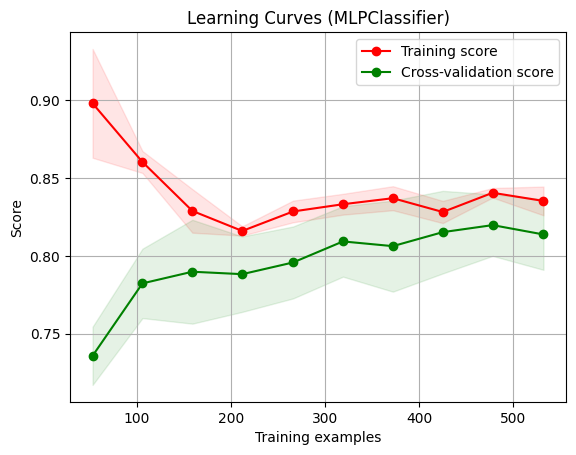

In [ ]:

print("Resultado parametros padrões (1 camda):")
infoClassificador(mlp1, y_test, X_test)

print("Gráfico de curva de aprendizado parametros padrões (1 camada):")

plot_learning_curves(mlp1, X_train, y_train)
plt.show()

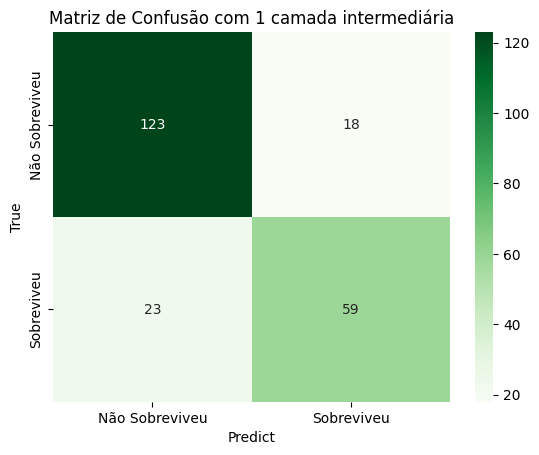


Acurácia do modelo 0.8161434977578476
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       141
           1       0.77      0.72      0.74        82

    accuracy                           0.82       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.82      0.81       223



In [ ]:
plot_confusion_matrix("Matriz de Confusão com 1 camada intermediária", mlp1, X_test, y_test)
infoClassificador(mlp1, y_test, X_test)

Resultado balanceado e sem mudança de hiperparametros (1 camda):

Acurácia do modelo 0.8161434977578476
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       141
           1       0.77      0.72      0.74        82

    accuracy                           0.82       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.82      0.81       223

Gráfico de curva de aprendizado sem mudança de hiperparametros (1 camada):


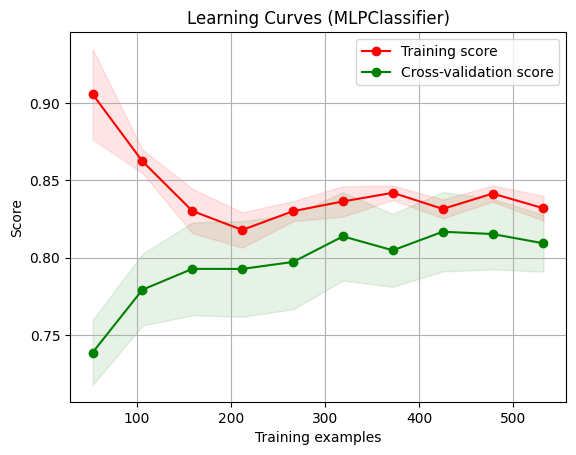

In [ ]:
print("Resultado balanceado e sem mudança de hiperparametros (1 camda):")

infoClassificador(mlp1, y_test, X_test)
print("Gráfico de curva de aprendizado sem mudança de hiperparametros (1 camada):")

plot_learning_curves(mlp1, X_train, y_train)
plt.show()

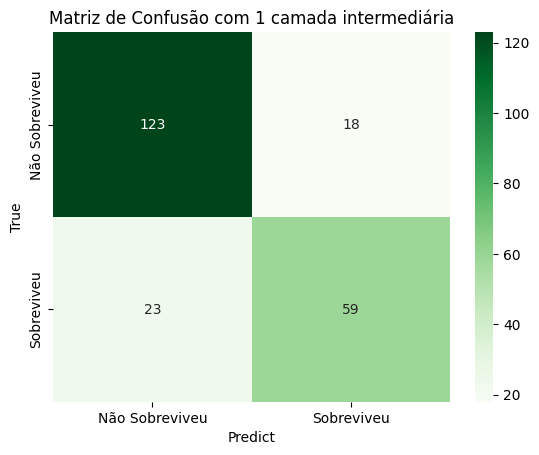


Acurácia do modelo 0.8161434977578476
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       141
           1       0.77      0.72      0.74        82

    accuracy                           0.82       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.82      0.81       223



In [ ]:
plot_confusion_matrix("Matriz de Confusão com 1 camada intermediária", mlp1, X_test, y_test)
infoClassificador(mlp1, y_test, X_test)

Resultado balanceado e com mudança de hiperparametros (1 camda):

Acurácia do modelo 0.8116591928251121
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       141
           1       0.75      0.73      0.74        82

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223

Gráfico de curva de aprendizado com mudança de hiperparametros (1 camada):


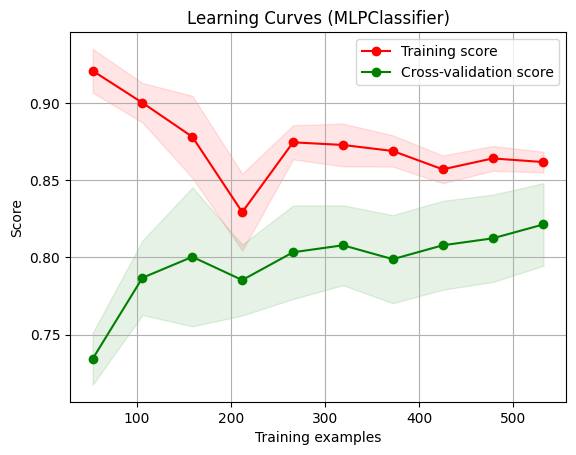

In [ ]:
print("Resultado balanceado e com mudança de hiperparametros (1 camda):")

infoClassificador(mlp1_alter, y_test, X_test)
print("Gráfico de curva de aprendizado com mudança de hiperparametros (1 camada):")

plot_learning_curves(mlp1_alter, X_train, y_train)
plt.show()

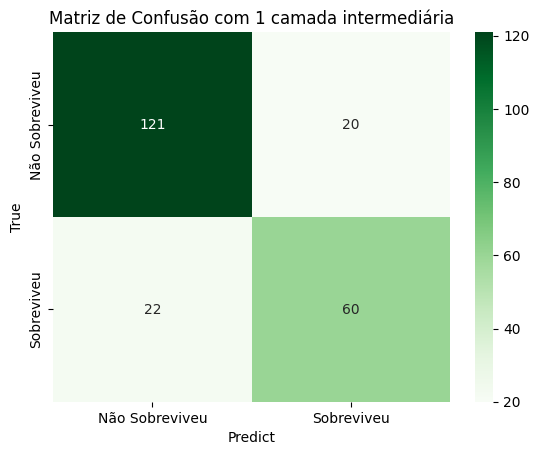

In [ ]:
plot_confusion_matrix("Matriz de Confusão com 1 camada intermediária", mlp1_alter, X_test, y_test)

*É* mais fácil pra rede identificar quando a pessoa tem chance de morrer

In [ ]:
## Com 2 camadas intermediárias

## Aqui aumentamos as camadas

## gostei desse resultado
mlp2 = MLPClassifier(hidden_layer_sizes=(200, 100)).fit(X_train, y_train)

# 'learning_rate': 'constant', 'max_iter': 200
#mlp2 = MLPClassifier(tol= 0.0061, solver= 'adam', max_iter = 320, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'early_stopping': False, 'activation': 'relu')
mlp2_alter = MLPClassifier( max_iter=300, batch_size= 50, learning_rate='constant', hidden_layer_sizes=(200, 100), activation='relu').fit(X_train, y_train)


infoClassificador(mlp2_alter, y_test, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




Acurácia do modelo 0.7892376681614349
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       141
           1       0.73      0.67      0.70        82

    accuracy                           0.79       223
   macro avg       0.78      0.76      0.77       223
weighted avg       0.79      0.79      0.79       223



Resultado sem estar balanceado e parametros padrões (2 camdas):

Acurácia do modelo 0.8026905829596412
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       141
           1       0.76      0.68      0.72        82

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223

Gráfico de curva de aprendizado parametros padrões (2 camadas):


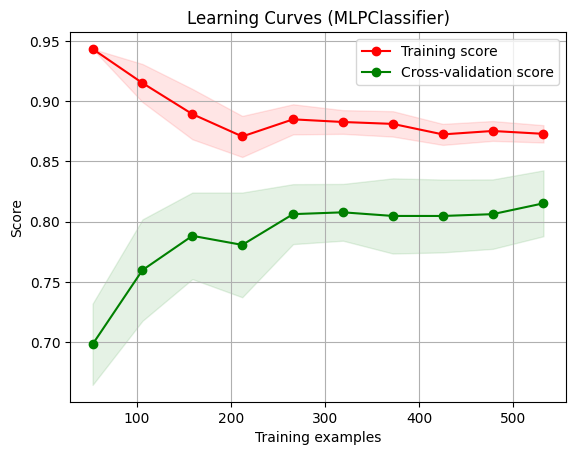

In [ ]:
print("Resultado sem estar balanceado e parametros padrões (2 camdas):")
infoClassificador(mlp2, y_test, X_test)

print("Gráfico de curva de aprendizado parametros padrões (2 camadas):")

plot_learning_curves(mlp2, X_train, y_train)
plt.show()

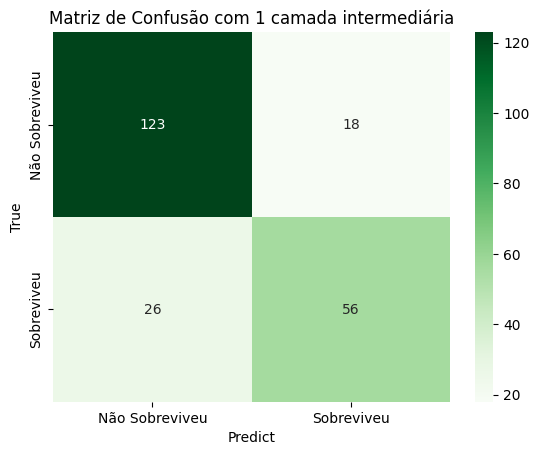

In [ ]:
plot_confusion_matrix("Matriz de Confusão com 1 camada intermediária", mlp2, X_test, y_test)

Resultado balanceado e sem mudança de hiperparametros (2 camdas):

Acurácia do modelo 0.8026905829596412
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       141
           1       0.76      0.68      0.72        82

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223

Gráfico de curva de aprendizado sem mudança de hiperparametros (2 camadas):


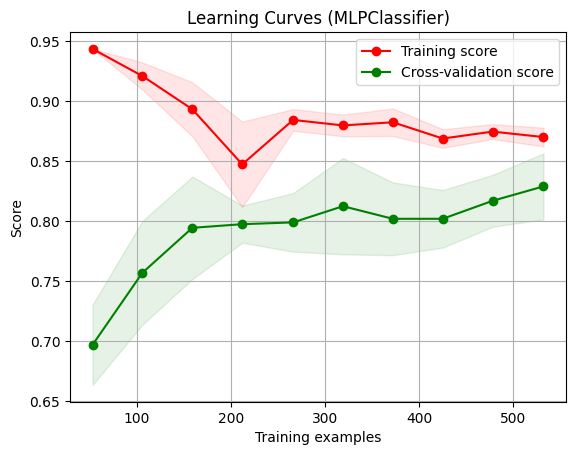

In [ ]:
print("Resultado balanceado e sem mudança de hiperparametros (2 camdas):")

infoClassificador(mlp2, y_test, X_test)
print("Gráfico de curva de aprendizado sem mudança de hiperparametros (2 camadas):")

plot_learning_curves(mlp2, X_train, y_train)
plt.show()

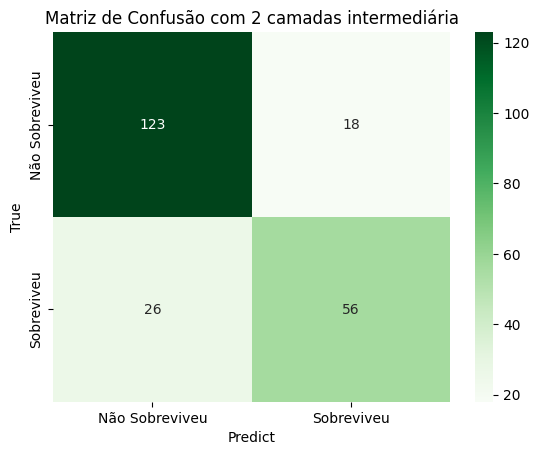

In [ ]:
plot_confusion_matrix("Matriz de Confusão com 2 camadas intermediária", mlp2, X_test, y_test)

Resultado balanceado e com mudança de hiperparametros (2 camdas):

Acurácia do modelo 0.7892376681614349
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       141
           1       0.73      0.67      0.70        82

    accuracy                           0.79       223
   macro avg       0.78      0.76      0.77       223
weighted avg       0.79      0.79      0.79       223

Gráfico de curva de aprendizado sem mudança de hiperparametros (2 camadas):


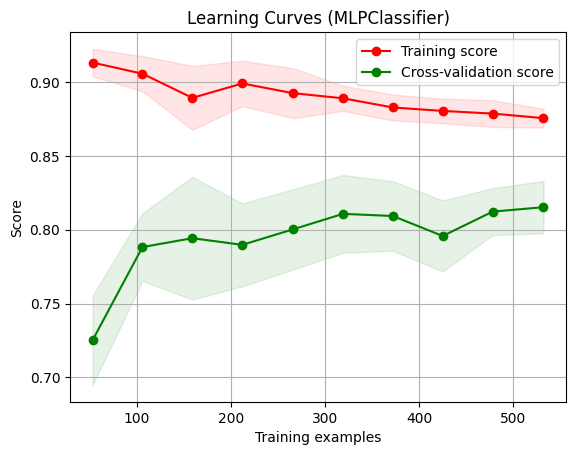

In [ ]:
print("Resultado balanceado e com mudança de hiperparametros (2 camdas):")

infoClassificador(mlp2_alter, y_test, X_test)
print("Gráfico de curva de aprendizado sem mudança de hiperparametros (2 camadas):")

plot_learning_curves(mlp2_alter, X_train, y_train)
plt.show()

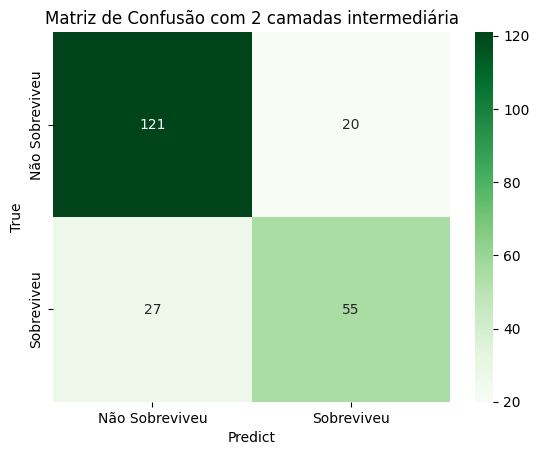

In [ ]:
plot_confusion_matrix("Matriz de Confusão com 2 camadas intermediária", mlp2_alter, X_test, y_test)

## Após a otimização de Age

### Age separado em "adulto" e "não adulto"

In [ ]:
mlp1 = MLPClassifier(hidden_layer_sizes=(100, )).fit(X_train, y_train)

## 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'max_iter': 500, 'early_stopping': 0
##   activation='tanh', alpha= 0.01, max_iter=100, validation_fraction=0.1,
mlp1_alter = MLPClassifier(hidden_layer_sizes=(200),  learning_rate = 'adaptive', max_iter = 500).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
## Com 2 camadas intermediárias

mlp2 = MLPClassifier(hidden_layer_sizes=(200, 100)).fit(X_train, y_train)

# valores estimados pela função de hiper parametro
mlp2_alter = MLPClassifier( max_iter=300, batch_size= 50, learning_rate='constant', hidden_layer_sizes=(200, 100), activation='relu').fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultado parametros padrões (1 camda):

Acurácia do modelo 0.8109090909090909
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       138
           1       0.81      0.82      0.81       137

    accuracy                           0.81       275
   macro avg       0.81      0.81      0.81       275
weighted avg       0.81      0.81      0.81       275

Gráfico de curva de aprendizado parametros padrões (1 camada):


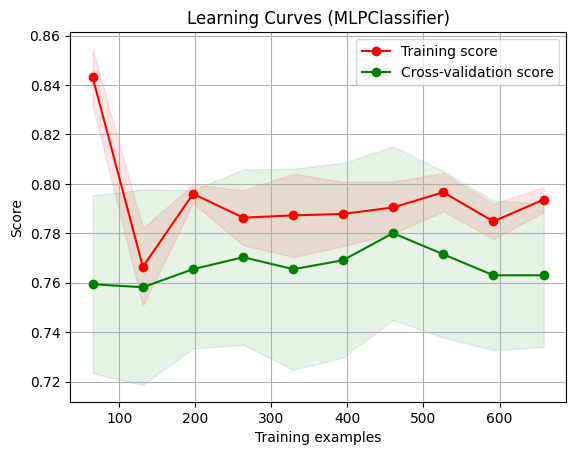

In [ ]:
print("Resultado parametros padrões (1 camda):")
infoClassificador(mlp1, y_test, X_test)

print("Gráfico de curva de aprendizado parametros padrões (1 camada):")

plot_learning_curves(mlp1, X_train, y_train)
plt.show()

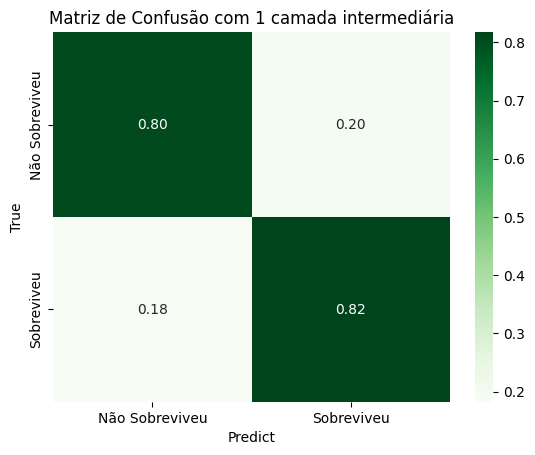


Acurácia do modelo 0.8109090909090909
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       138
           1       0.81      0.82      0.81       137

    accuracy                           0.81       275
   macro avg       0.81      0.81      0.81       275
weighted avg       0.81      0.81      0.81       275



In [ ]:
plot_confusion_matrix("Matriz de Confusão com 1 camada intermediária", mlp1, X_test, y_test)
infoClassificador(mlp1, y_test, X_test)

Resultado  max otimizado (1 camda):

Acurácia do modelo 0.8181818181818182
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       138
           1       0.81      0.82      0.82       137

    accuracy                           0.82       275
   macro avg       0.82      0.82      0.82       275
weighted avg       0.82      0.82      0.82       275

Gráfico de curva de aprendizado max otimizado (1 camada):


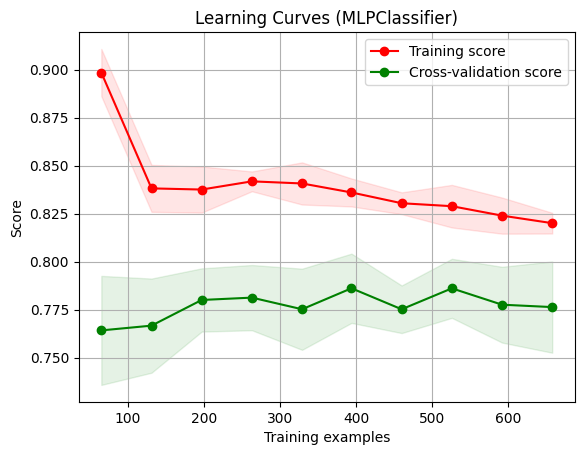

In [ ]:
print("Resultado  max otimizado (1 camda):")
infoClassificador(mlp1_alter, y_test, X_test)

print("Gráfico de curva de aprendizado max otimizado (1 camada):")

plot_learning_curves(mlp1_alter, X_train, y_train)
plt.show()

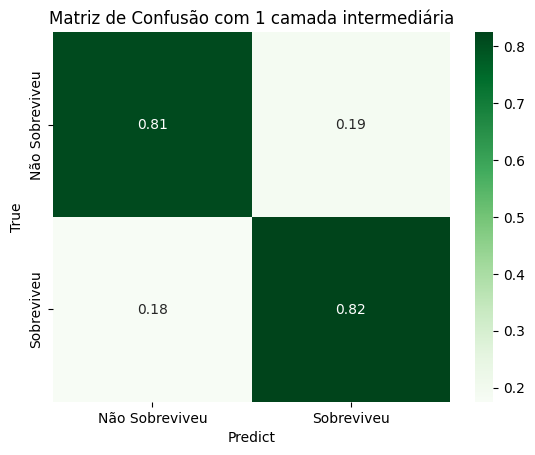


Acurácia do modelo 0.8181818181818182
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       138
           1       0.81      0.82      0.82       137

    accuracy                           0.82       275
   macro avg       0.82      0.82      0.82       275
weighted avg       0.82      0.82      0.82       275



In [ ]:
plot_confusion_matrix("Matriz de Confusão com 1 camada intermediária", mlp1_alter, X_test, y_test)
infoClassificador(mlp1_alter, y_test, X_test)

------------------------- COM DUAS CAMADAS ----------------------------------

Resultado parametros padrões (2 camdas):

Acurácia do modelo 0.8036363636363636
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       138
           1       0.85      0.73      0.79       137

    accuracy                           0.80       275
   macro avg       0.81      0.80      0.80       275
weighted avg       0.81      0.80      0.80       275

Gráfico de curva de aprendizado parametros padrões (2 camadas):


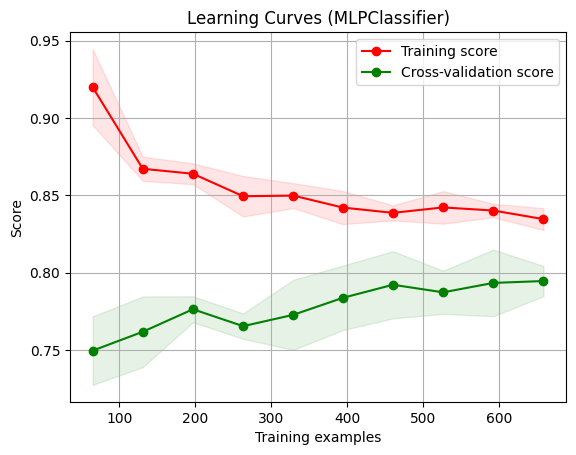

In [ ]:
print("Resultado parametros padrões (2 camdas):")
infoClassificador(mlp2, y_test, X_test)

print("Gráfico de curva de aprendizado parametros padrões (2 camadas):")

plot_learning_curves(mlp2, X_train, y_train)
plt.show()

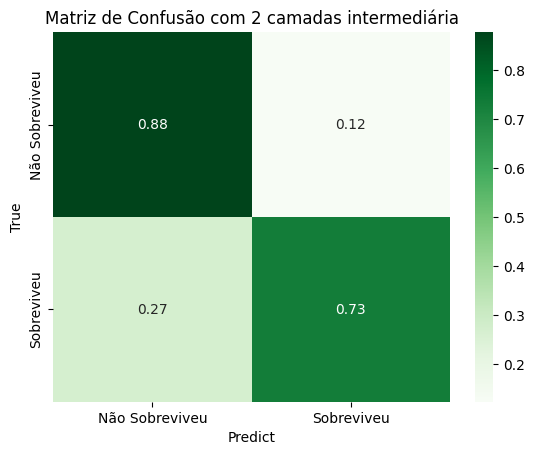


Acurácia do modelo 0.8036363636363636
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       138
           1       0.85      0.73      0.79       137

    accuracy                           0.80       275
   macro avg       0.81      0.80      0.80       275
weighted avg       0.81      0.80      0.80       275



In [ ]:
plot_confusion_matrix("Matriz de Confusão com 2 camadas intermediária", mlp2, X_test, y_test)
infoClassificador(mlp2, y_test, X_test)

Resultado parametros padrões (2 camdas):

Acurácia do modelo 0.7927272727272727
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       138
           1       0.74      0.89      0.81       137

    accuracy                           0.79       275
   macro avg       0.80      0.79      0.79       275
weighted avg       0.80      0.79      0.79       275

Gráfico parametros otimizados (2 camadas):


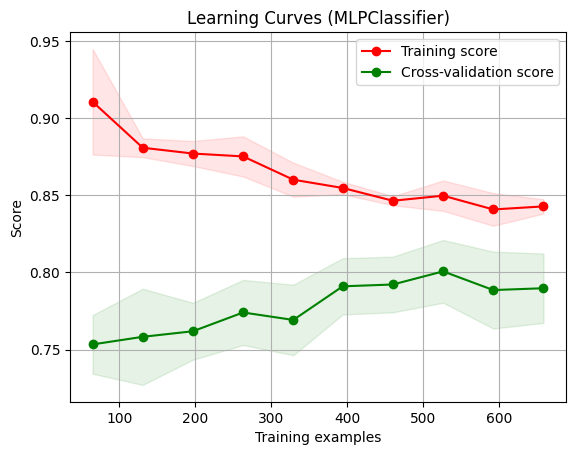

In [ ]:
print("Resultado parametros padrões (2 camdas):")
infoClassificador(mlp2_alter, y_test, X_test)

print("Gráfico parametros otimizados (2 camadas):")

plot_learning_curves(mlp2_alter, X_train, y_train)
plt.show()

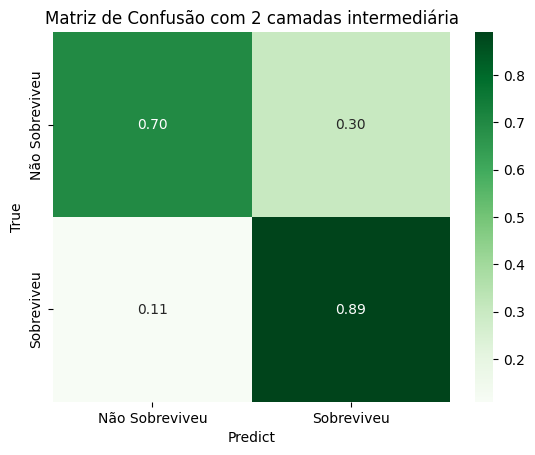


Acurácia do modelo 0.7927272727272727
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       138
           1       0.74      0.89      0.81       137

    accuracy                           0.79       275
   macro avg       0.80      0.79      0.79       275
weighted avg       0.80      0.79      0.79       275



In [ ]:
plot_confusion_matrix("Matriz de Confusão com 2 camadas intermediária", mlp2_alter, X_test, y_test)
infoClassificador(mlp2_alter, y_test, X_test)

#Validação do Treinamento

Quantidade de épocas puramente ilustrativas **

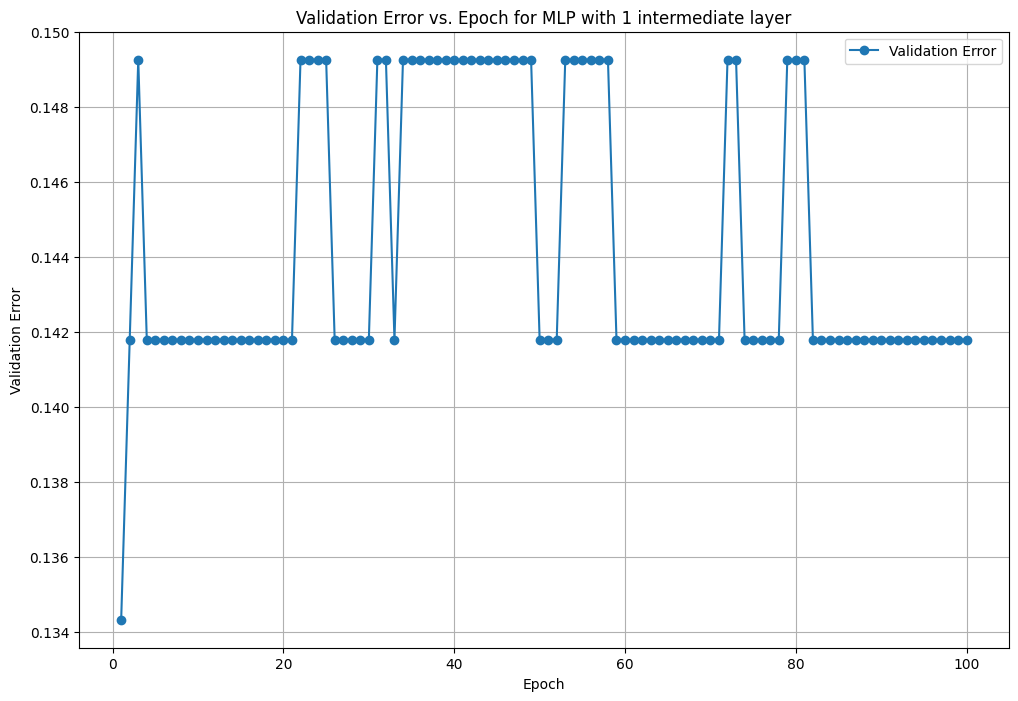

In [ ]:
plot_validation_error_vs_epoch(mlp1, 'Validation Error vs. Epoch for MLP with 1 intermediate layer',  X_train, y_train)

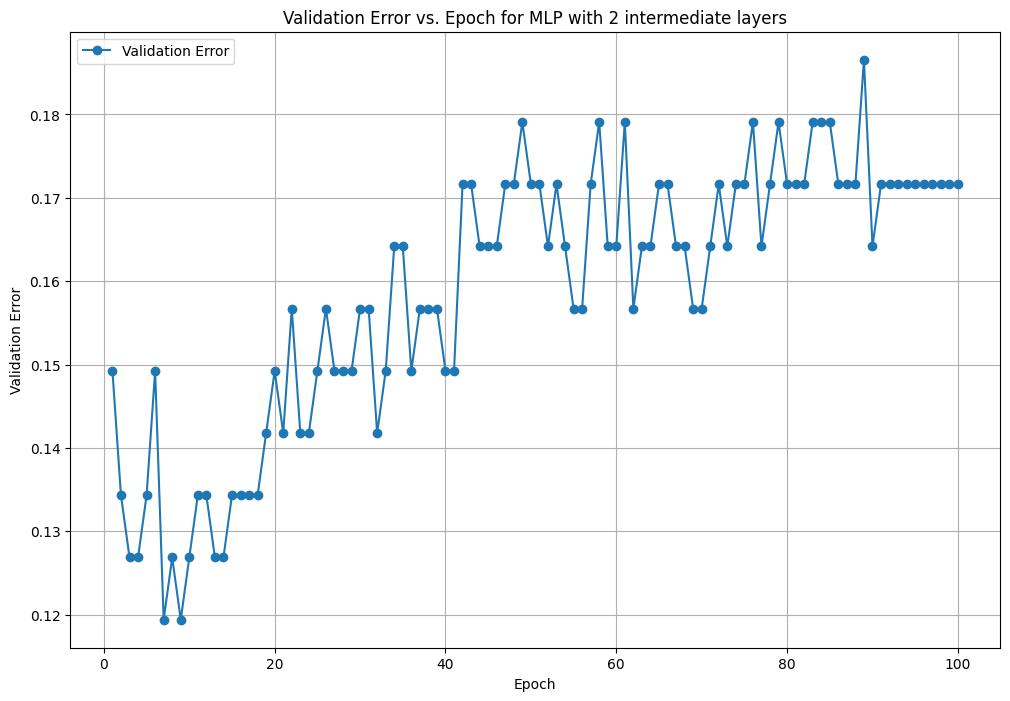

In [ ]:
plot_validation_error_vs_epoch(mlp2,'Validation Error vs. Epoch for MLP with 2 intermediate layers',  X_train, y_train)

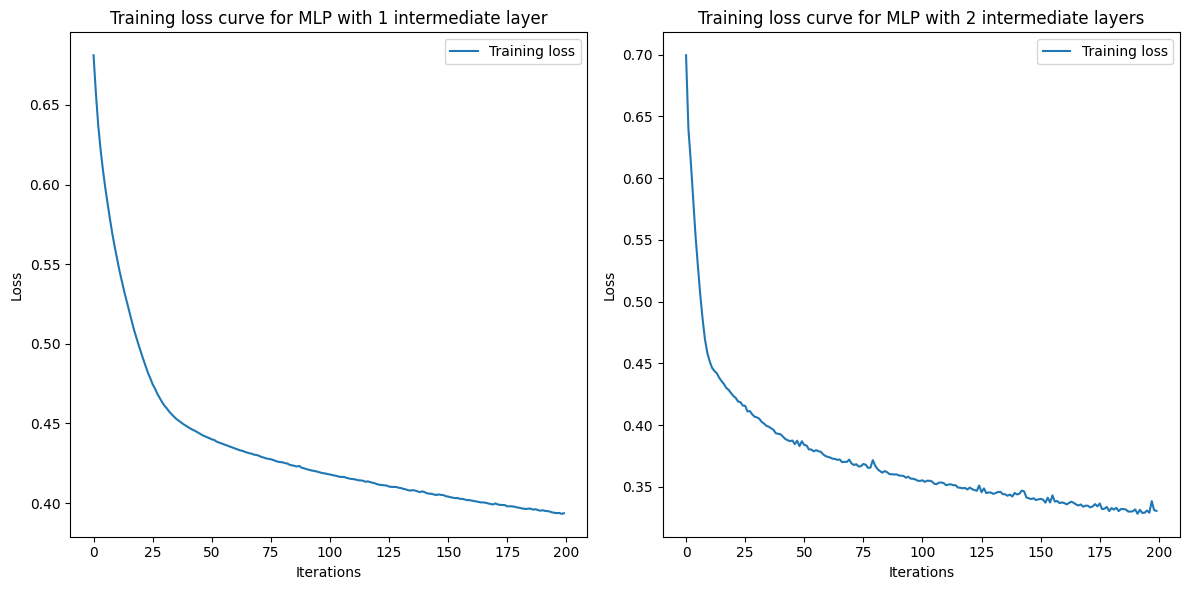

In [ ]:
# Plotar as curvas de perda
plt.figure(figsize=(12, 6))

# Modelo com 1 camada intermediária
plt.subplot(1, 2, 1)
plt.plot(mlp1.loss_curve_, label='Training loss')
plt.title('Training loss curve for MLP with 1 intermediate layer')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Modelo com 2 camadas intermediárias
plt.subplot(1, 2, 2)
plt.plot(mlp2.loss_curve_, label='Training loss')
plt.title('Training loss curve for MLP with 2 intermediate layers')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()